In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster

import matplotlib.pyplot as plt
import cartopy
import cmocean
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from scipy import stats
import utils

import metpy.calc as mpcalc

#### Define case and path

In [2]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'

In [3]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

#### Get grid

In [4]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3') #.isel(nlon=slice(500,1100),nlat=slice(1600,2000))
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

#### Define variable list

In [5]:
variables = ['x_graze_mesozoo_zint', 'photoC_diaz_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint', 'SSH']
coords = {'x':'TLONG','y':'TLAT'}
keep_vars=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

In [6]:
def preprocess(ds):
    #ds=ds.isel(z_t=0)
    ds=ds.mean(dim=['time']).compute()
    return ds

In [7]:
%%time

ds_ann_fosi = xr.Dataset()

#for year in np.arange(1997,2018,1):
for year in np.arange(1997,2000,1):
    yr4="{:04d}".format(year)
    ds = xr.Dataset()
    print(year)
    for v in variables:  
        print(v)
        files = sorted(glob(f'{path}/{case}.pop.h.{v}.{yr4}01-{yr4}12.nc'))
        
        dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], combine='nested',decode_times=True,preprocess=preprocess)

        ds = xr.merge((ds, dsv))

    ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()
    
    ## add it to the annual file
    ds_ann_fosi = xr.concat([ds_ann_fosi, ds], "time")

1997
x_graze_mesozoo_zint
photoC_diaz_zint
photoC_diat_zint
photoC_sp_zint
photoC_cocco_zint
SSH
1998
x_graze_mesozoo_zint
photoC_diaz_zint
photoC_diat_zint
photoC_sp_zint
photoC_cocco_zint
SSH
1999
x_graze_mesozoo_zint
photoC_diaz_zint
photoC_diat_zint
photoC_sp_zint
photoC_cocco_zint
SSH
CPU times: user 2min 24s, sys: 49.2 s, total: 3min 13s
Wall time: 3min 38s


In [8]:
ds_ann_fosi['photoC_TOT_zint'] = ds_ann_fosi['photoC_cocco_zint'] + ds_ann_fosi['photoC_diat_zint'] + ds_ann_fosi['photoC_diaz_zint'] + ds_ann_fosi['photoC_sp_zint']

In [9]:
ds_ann_fosi['zratio'] = ds_ann_fosi['x_graze_mesozoo_zint']/ds_ann_fosi['photoC_TOT_zint']

### spin up dask

In [10]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='06:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [11]:
# cluster, client = get_ClusterClient()
# cluster.scale(12) 
# client

In [12]:
ds_mean = ds_ann_fosi.mean(dim='time').load()

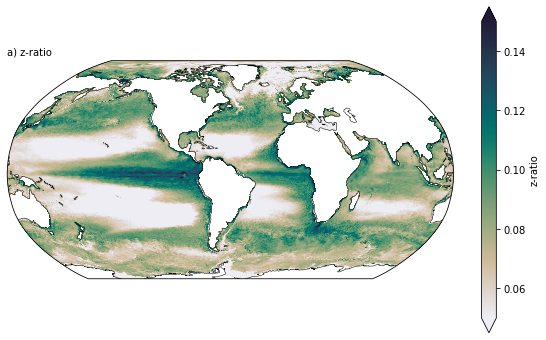

In [13]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) z-ratio', fontsize=10,loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_mean.zratio)
pc=ax.pcolormesh(lon, lat, field, cmap=cmocean.cm.rain,vmin=0.05,vmax=0.15,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)




cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='z-ratio')

## SNAPSHOTS

In [14]:
year=2020

### Just grab one year of daily data

In [15]:
variables = ['photoC_diat_zint_2', 'photoC_cocco_zint_2','photoC_sp_zint_2','photoC_diaz_zint_2','mesozooC_zint_150m', 'SSH_2','HMXL_2']
coords = {'x':'TLONG','y':'TLAT'}
keep_vars=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

In [16]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/day_1'

In [17]:
ds_d1_oneyear = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob(f'{path}/{case}.pop.h.nday1.{var}.{year}????-{year+1}????.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_d1_oneyear = xr.merge([ds_d1_oneyear,ds_tmp])

starting on  photoC_diat_zint_2
starting on  photoC_cocco_zint_2
starting on  photoC_sp_zint_2
starting on  photoC_diaz_zint_2
starting on  mesozooC_zint_150m
starting on  SSH_2
starting on  HMXL_2


### Grab one year of 5 day Fe data

In [18]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/day_5'
variables = ['Fe_z_t_150m','diat_light_lim_Cweight_avg_100m','TEMP_z_t_150m']
coords = {'x':'TLONG','y':'TLAT'}
keep_vars=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

In [19]:
ds_d5_oneyear = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob(f'{path}/{case}.pop.h.nday5.{var}.{year}????-{year}????.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_d5_oneyear = xr.merge([ds_d5_oneyear,ds_tmp])

starting on  Fe_z_t_150m
starting on  diat_light_lim_Cweight_avg_100m
starting on  TEMP_z_t_150m


In [20]:
ds_d5_oneyear['time'] = ds_d5_oneyear.time_bound.compute().mean(dim="d2")

In [21]:
ds_d5_oneyear.time[66]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2020, 11, 29, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 2020-11-29 12:00:00

In [22]:
fe_ss_mean = ds_d5_oneyear.Fe_z_t_150m.isel(time=66).mean(dim='z_t_150m')

In [23]:
fe_ss_surf = ds_d5_oneyear.Fe_z_t_150m.isel(time=66,z_t_150m=0)

In [24]:
fe_ss_surf

<xarray.DataArray 'Fe_z_t_150m' (nlat: 2400, nlon: 3600)>
dask.array<getitem, shape=(2400, 3600), dtype=float32, chunksize=(2400, 3600), chunktype=numpy.ndarray>
Coordinates:
    z_t_150m  float32 500.0
    TLONG     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT      (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    time      object 2020-11-29 12:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Dissolved Inorganic Iron, top 150m
    units:         mmol/m^3
    grid_loc:      3114
    cell_methods:  time: mean

In [25]:
##### box in south indian where I'll be showing snapshots
box1_latmin = -55
box1_latmax = -40
box1_lonmin = 80.
box1_lonmax = 100.

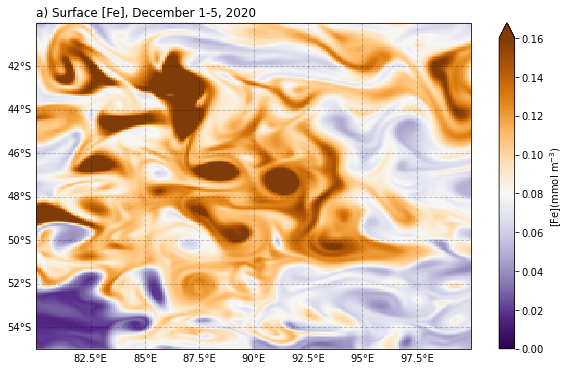

In [26]:
fig = plt.figure(figsize=(10,6))

############### 

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax.set_title('a) Surface [Fe], December 1-5, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, fe_ss_surf*1000)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='PuOr_r',
                    vmin=0,vmax=0.16
                  )


# lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
# cs = ax.contour(lon,lat,field, colors='red',
#     levels = np.arange(-10,12,2),
#     linewidths = 0.7,
#     transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='[Fe](mmol m$^{-3}$)')
    

In [27]:
doy=335

In [28]:
mesozoo_ss = ds_d1_oneyear['mesozooC_zint_150m'].isel(time=doy)
diatnpp_ss = ds_d1_oneyear['photoC_diat_zint_2'].isel(time=doy)

In [29]:
cocconpp_ss = ds_d1_oneyear['photoC_cocco_zint_2'].isel(time=doy)
spnpp_ss = ds_d1_oneyear['photoC_sp_zint_2'].isel(time=doy)
diaznpp_ss = ds_d1_oneyear['photoC_diaz_zint_2'].isel(time=doy)

In [30]:
totnpp_ss = diatnpp_ss + cocconpp_ss + spnpp_ss + diaznpp_ss
mld_ss = ds_d1_oneyear['HMXL_2'].isel(time=doy)

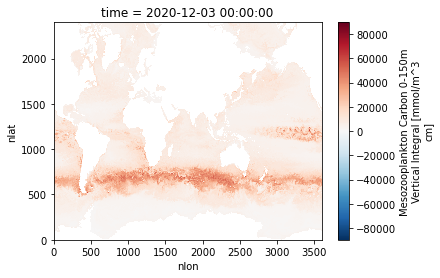

In [31]:
mesozoo_ss.plot()

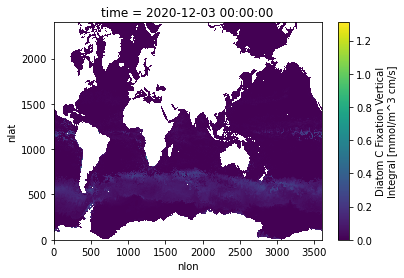

In [32]:
diatnpp_ss.plot()

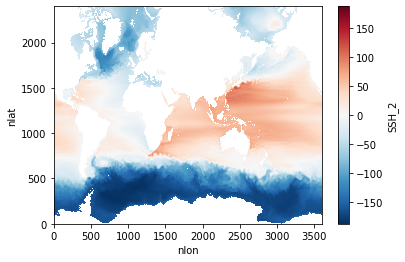

In [33]:
ds_d1_oneyear['SSH_2'].mean(dim='time').plot()

In [34]:
n_reps = 30 #for smoothing

anoms=np.empty([2400,3600])
mask=np.empty([2400,3600])

tmp = ds_d1_oneyear['SSH_2'].isel(time=doy)
tmp = mpcalc.smooth_n_point(tmp, 9, n_reps)
tmp = xr.DataArray(tmp,dims=('nlat','nlon'))
anoms[:,:] = ds_d1_oneyear['SSH_2'].isel(time=doy).values - tmp.values
mask[:,:] = np.isfinite(anoms[:,:])  
anoms = xr.DataArray(anoms, dims=('nlat','nlon'))
mask = xr.DataArray(mask, dims=('nlat','nlon'))
anoms = anoms.where(mask==1)

ssh_anoms = anoms

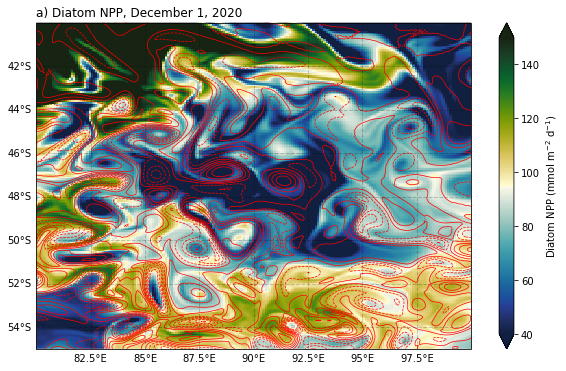

In [35]:
fig = plt.figure(figsize=(10,6))

############### 

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax.set_title('a) Diatom NPP, December 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, diatnpp_ss*0.01 * 86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                    vmin=40,vmax=150
                  )


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax.contour(lon,lat,field, colors='red',
    levels = np.arange(-10,12,2),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Diatom NPP (mmol m$^{-2}$ d$^{-1}$)')
    

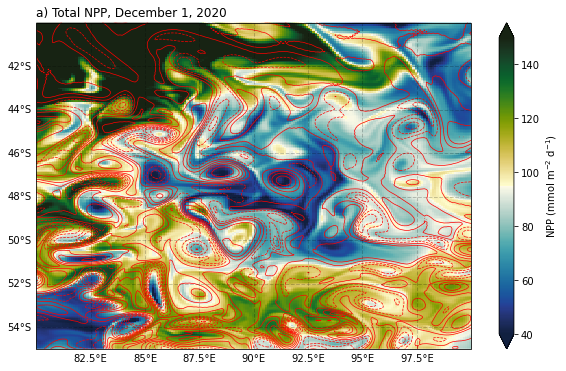

In [36]:
fig = plt.figure(figsize=(10,6))

############### 

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax.set_title('a) Total NPP, December 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, totnpp_ss*0.01 * 86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                    vmin=40,vmax=150
                  )


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax.contour(lon,lat,field, colors='red',
    levels = np.arange(-10,12,2),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='NPP (mmol m$^{-2}$ d$^{-1}$)')
    

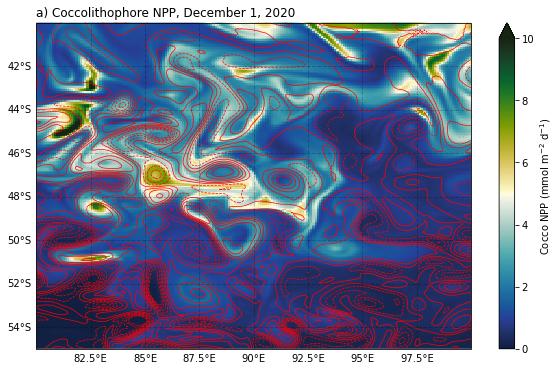

In [37]:
fig = plt.figure(figsize=(10,6))

############### 

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax.set_title('a) Coccolithophore NPP, December 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, cocconpp_ss*0.01 * 86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                    vmin=0,vmax=10
                  )


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax.contour(lon,lat,field, colors='red',
    levels = np.arange(-10,12,2),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Cocco NPP (mmol m$^{-2}$ d$^{-1}$)')
    

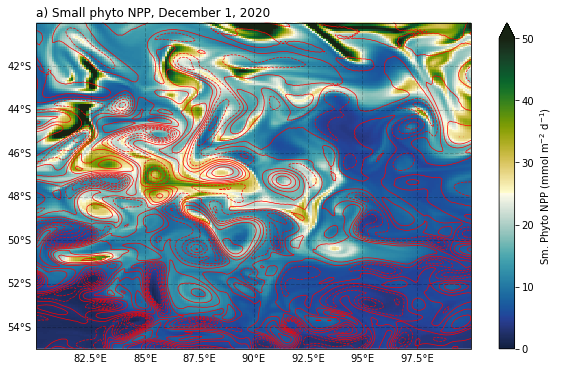

In [38]:
fig = plt.figure(figsize=(10,6))

############### 

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax.set_title('a) Small phyto NPP, December 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, spnpp_ss*0.01 * 86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                    vmin=0,vmax=50
                  )


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax.contour(lon,lat,field, colors='red',
    levels = np.arange(-10,12,2),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Sm. Phyto NPP (mmol m$^{-2}$ d$^{-1}$)')
    

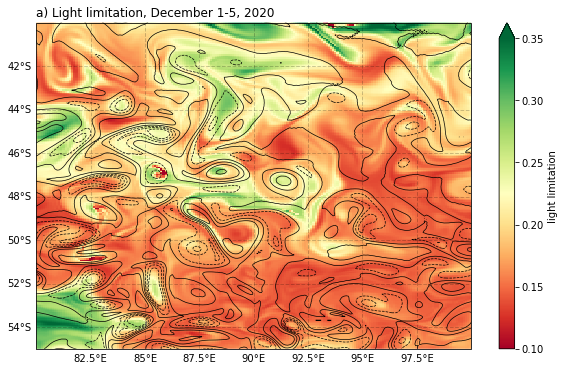

In [39]:
fig = plt.figure(figsize=(10,6))

############### 

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax.set_title('a) Light limitation, December 1-5, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_d5_oneyear.diat_light_lim_Cweight_avg_100m.isel(time=66))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='RdYlGn',
                    vmin=0.1,vmax=0.35
                  )


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax.contour(lon,lat,field, colors='black',
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='light limitation')
    

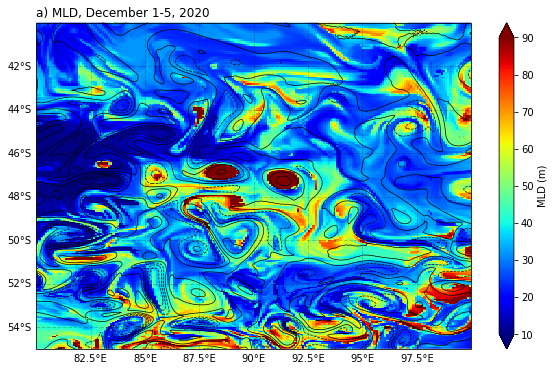

In [40]:
fig = plt.figure(figsize=(10,6))

############### 

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax.set_title('a) MLD, December 1-5, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_d1_oneyear.HMXL_2.isel(time=doy)*0.01)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='jet',
                    vmin=10,vmax=90
                  )


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax.contour(lon,lat,field, colors='black',
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='MLD (m)')
    

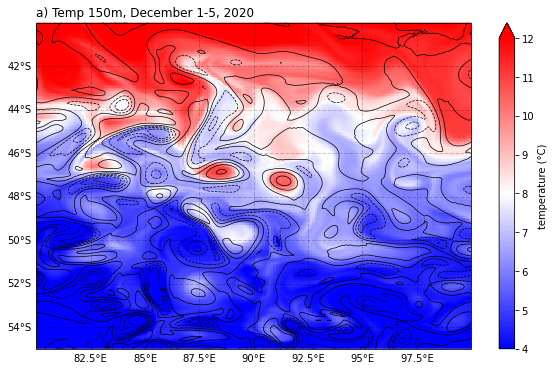

In [41]:
fig = plt.figure(figsize=(10,6))

############### 

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax.set_title('a) Temp 150m, December 1-5, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_d5_oneyear.TEMP_z_t_150m.isel(time=66,z_t_150m=0))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',
                    vmin=4,vmax=12
                  )


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax.contour(lon,lat,field, colors='black',
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='temperature (°C)')
    

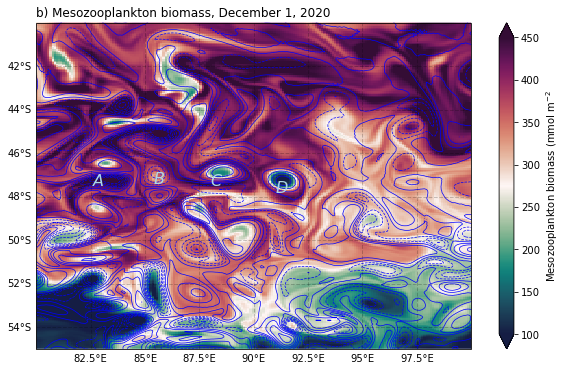

In [42]:
fig = plt.figure(figsize=(10,6))

############### 

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax.set_title('b) Mesozooplankton biomass, December 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, mesozoo_ss*0.01)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.curl,
                    vmin=100,vmax=450
                  )

ax.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='lightblue')
ax.text(85.4,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='lightblue')
ax.text(88,-47.5,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='lightblue')
ax.text(91,-47.8,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='lightblue')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax.contour(lon,lat,field, colors='blue',
    levels = np.arange(-10,12,2),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False


cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Mesozooplankton biomass (mmol m$^{-2}$')

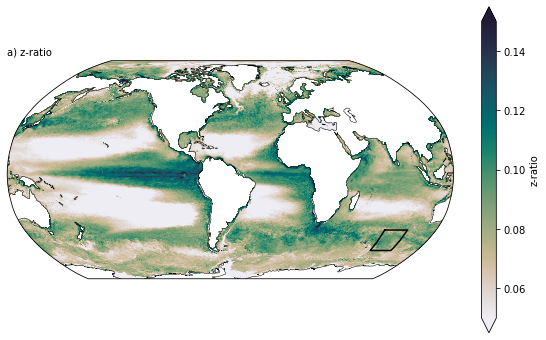

In [43]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) z-ratio', fontsize=10,loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_mean.zratio)
pc=ax.pcolormesh(lon, lat, field, cmap=cmocean.cm.rain,vmin=0.05,vmax=0.15,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())


cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='z-ratio')

## get FEISTY!

In [44]:
print(year)
yr4="{:04d}".format(year)
path = '/glade/derecho/scratch/eromashkova/feisty_output/test_10092023/hist/highres.' + yr4 + '.zarr'

ds_oneyear_feisty = xr.open_zarr(path, consolidated=False)

2020


In [ ]:
ds_oneyear_feisty

In [46]:
forage_ss = ds_oneyear_feisty['biomass'].isel(time=doy).sel(group='Sf') + ds_oneyear_feisty['biomass'].isel(time=doy).sel(group='Mf')
forage_ss = forage_ss.load()

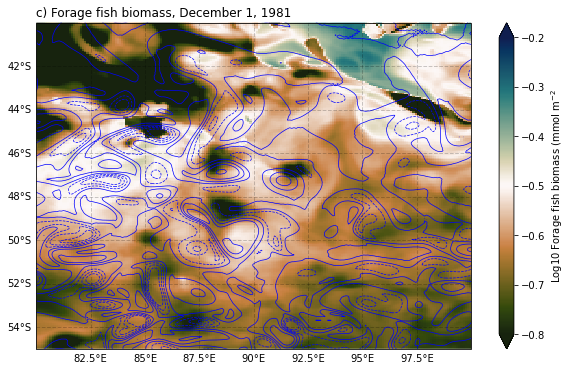

In [47]:
fig = plt.figure(figsize=(10,6))

############### 

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax.set_title('c) Forage fish biomass, December 1, 1981', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, np.log10(forage_ss/12.))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.tarn,
                    vmin=-0.8,vmax=-0.2
                  )


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax.contour(lon,lat,field, colors='blue',
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False


cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Log10 Forage fish biomass (mmol m$^{-2}$')

In [48]:
pelagic_ss = ds_oneyear_feisty['biomass'].isel(time=doy).sel(group='Sp') + ds_oneyear_feisty['biomass'].isel(time=doy).sel(group='Mp')+ ds_oneyear_feisty['biomass'].isel(time=doy).sel(group='Lp')
lpelagic_ss = ds_oneyear_feisty['biomass'].isel(time=doy).sel(group='Lp')

pelagic_ss = pelagic_ss.load()

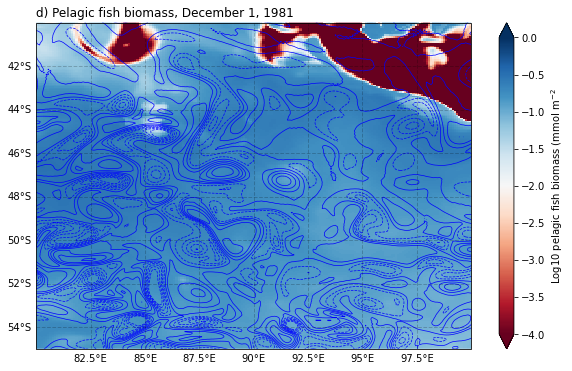

In [49]:
fig = plt.figure(figsize=(10,6))

############### 

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax.set_title('d) Pelagic fish biomass, December 1, 1981', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, np.log10(pelagic_ss/12.))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='RdBu', #cmocean.cm.delta,
                    vmin=-4,vmax=0
                  )


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax.contour(lon,lat,field, colors='blue',
    levels = np.arange(-10,12,2),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False


cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Log10 pelagic fish biomass (mmol m$^{-2}$')

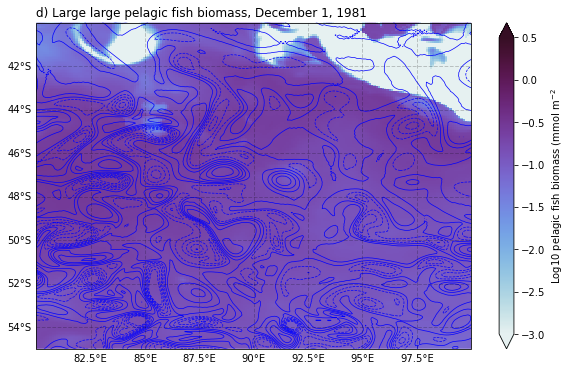

In [50]:
fig = plt.figure(figsize=(10,6))

############### 

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

ax.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax.set_title('d) Large large pelagic fish biomass, December 1, 1981', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, np.log10(pelagic_ss/12.))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.dense,
                    vmin=-3,vmax=0.5
                  )


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax.contour(lon,lat,field, colors='blue',
    levels = np.arange(-10,12,2),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False


cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Log10 pelagic fish biomass (mmol m$^{-2}$')

### Put all the maps together

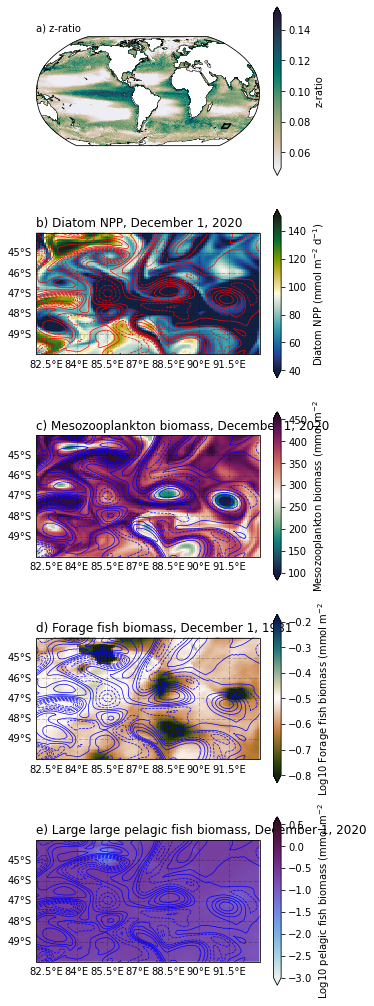

In [60]:
fig = plt.figure(figsize=(5,18))

###############################
ax = fig.add_subplot(5,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) z-ratio', fontsize=10,loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_mean.zratio)
pc=ax.pcolormesh(lon, lat, field, cmap=cmocean.cm.rain,vmin=0.05,vmax=0.15,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='z-ratio')


############################

ax = fig.add_subplot(5,1,2, projection=ccrs.PlateCarree())

ax.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax.set_title('b) Diatom NPP, December 1, '+str(year), loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, diatnpp_ss*0.01 * 86400.)
pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                    vmin=40,vmax=150
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax.contour(lon,lat,field, colors='red',
    levels = np.arange(-10,12,2),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Diatom NPP (mmol m$^{-2}$ d$^{-1}$)')

###########################

ax = fig.add_subplot(5,1,3, projection=ccrs.PlateCarree())
ax.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax.set_title('c) Mesozooplankton biomass, December 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, mesozoo_ss*0.01)
pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.curl,
                    vmin=100,vmax=450)


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax.contour(lon,lat,field, colors='blue',
    levels = np.arange(-10,12,2),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Mesozooplankton biomass (mmol m$^{-2}$')

############### 
ax = fig.add_subplot(5,1,4, projection=ccrs.PlateCarree())

ax.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax.set_title('d) Forage fish biomass, December 1, 1981', loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, np.log10(forage_ss/12.))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.tarn,
                    vmin=-0.8,vmax=-0.2)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax.contour(lon,lat,field, colors='blue',
    levels = np.arange(-10,12,2),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Log10 Forage fish biomass (mmol m$^{-2}$')

############### 

ax = fig.add_subplot(5,1,5, projection=ccrs.PlateCarree())

ax.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax.set_title('e) Large large pelagic fish biomass, December 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, np.log10(pelagic_ss/12.))

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.dense,
                    vmin=-3,vmax=0.5)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax.contour(lon,lat,field, colors='blue',
    levels = np.arange(-10,12,2),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Log10 pelagic fish biomass (mmol m$^{-2}$')

In [61]:
import matplotlib.gridspec as gridspec

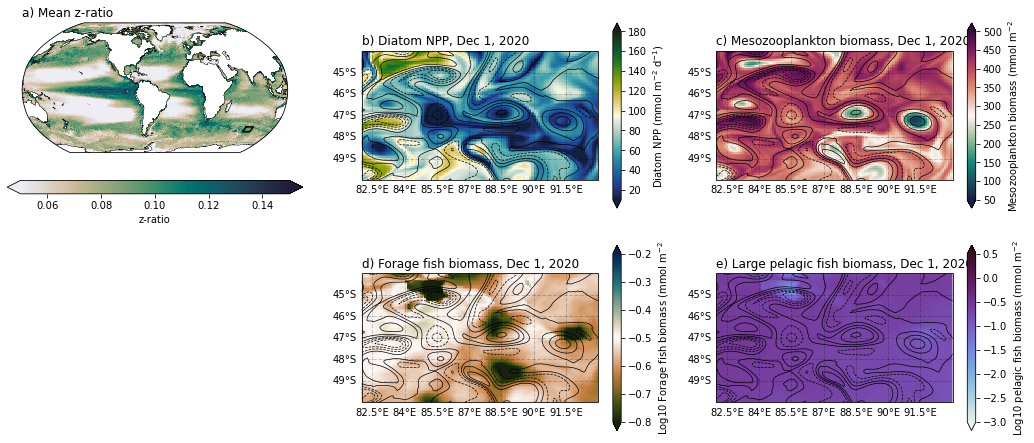

In [62]:
fig = plt.figure(figsize=(18, 7.5))

gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1,1), height_ratios=(1,1))

prj = ccrs.Robinson(central_longitude=305.0)
prj_box = ccrs.PlateCarree()

ax_zratio = plt.subplot(gs[0,0], projection=prj)

ax_diat = plt.subplot(gs[0,1], projection=prj_box)
ax_meso = plt.subplot(gs[0,2], projection=prj_box)
ax_forage = plt.subplot(gs[1,1], projection=prj_box)
ax_lp = plt.subplot(gs[1,2], projection=prj_box)

sshcolor = 'black'

##################

ax_zratio.set_title('a) Mean z-ratio', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_mean.zratio)
pc=ax_zratio.pcolormesh(lon, lat, field, cmap=cmocean.cm.rain,vmin=0.05,vmax=0.15,transform=ccrs.PlateCarree())
ax_zratio.coastlines('110m',linewidth=0.5)

lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax_zratio.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax_zratio,extend='both',label='z-ratio',orientation='horizontal')

############################

ax_diat.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax_diat.set_title('b) Diatom NPP, Dec 1, '+str(year), loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, diatnpp_ss*0.01 * 86400.)
pc = ax_diat.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                    vmin=10,vmax=180
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_diat.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_diat.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax_diat,extend='both',label='Diatom NPP (mmol m$^{-2}$ d$^{-1}$)')


###########################

ax_meso.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax_meso.set_title('c) Mesozooplankton biomass, Dec 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, mesozoo_ss*0.01)
pc = ax_meso.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.curl,
                    vmin=50,vmax=500)


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_meso.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_meso.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax_meso,extend='both',label='Mesozooplankton biomass (mmol m$^{-2}$')

############### 

ax_forage.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax_forage.set_title('d) Forage fish biomass, Dec 1, '+str(year), loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, np.log10(forage_ss/12.))

pc = ax_forage.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.tarn,
                    vmin=-0.8,vmax=-0.2)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_forage.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_forage.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax_forage,extend='both',label='Log10 Forage fish biomass (mmol m$^{-2}$')

############### 

ax_lp.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax_lp.set_title('e) Large pelagic fish biomass, Dec 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, np.log10(pelagic_ss/12.))

pc = ax_lp.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.dense,
                    vmin=-3,vmax=0.5)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_lp.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_lp.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax_lp,extend='both',label='Log10 pelagic fish biomass (mmol m$^{-2}$')

fig.savefig('/glade/work/kristenk/figs/z-ratio_npp2fish_ss.png', bbox_inches='tight', dpi=300, format='png');

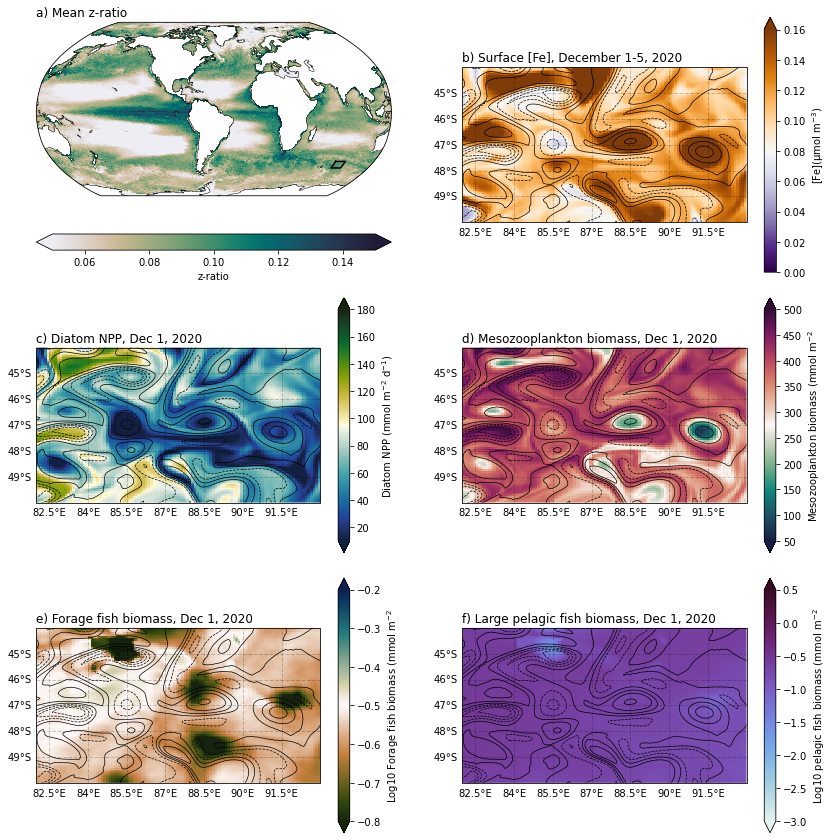

In [63]:
fig = plt.figure(figsize=(14, 15))

gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=(1, 1), height_ratios=(1,1,1))

prj = ccrs.Robinson(central_longitude=305.0)
prj_box = ccrs.PlateCarree()

ax_zratio = plt.subplot(gs[0,0], projection=prj)
ax_fe = plt.subplot(gs[0,1], projection=prj_box)
ax_diat = plt.subplot(gs[1,0], projection=prj_box)
ax_meso = plt.subplot(gs[1,1], projection=prj_box)
ax_forage = plt.subplot(gs[2,0], projection=prj_box)
ax_lp = plt.subplot(gs[2,1], projection=prj_box)

sshcolor = 'black'

##################

ax_zratio.set_title('a) Mean z-ratio', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_mean.zratio)
pc=ax_zratio.pcolormesh(lon, lat, field, cmap=cmocean.cm.rain,vmin=0.05,vmax=0.15,transform=ccrs.PlateCarree())
ax_zratio.coastlines('110m',linewidth=0.5)

lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax_zratio.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax_zratio,extend='both',label='z-ratio',orientation='horizontal')


##################

ax_fe.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax_fe.set_title('b) Surface [Fe], December 1-5, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, fe_ss_surf*1000)

pc = ax_fe.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='PuOr_r',
                    vmin=0,vmax=0.16
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_fe.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_fe.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax_fe,extend='max',label='[Fe](µmol m$^{-3}$)')
    


############################

ax_diat.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax_diat.set_title('c) Diatom NPP, Dec 1, '+str(year), loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, diatnpp_ss*0.01 * 86400.)
pc = ax_diat.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                    vmin=10,vmax=180
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_diat.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_diat.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax_diat,extend='both',label='Diatom NPP (mmol m$^{-2}$ d$^{-1}$)')


###########################

ax_meso.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax_meso.set_title('d) Mesozooplankton biomass, Dec 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, mesozoo_ss*0.01)
pc = ax_meso.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.curl,
                    vmin=50,vmax=500)


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_meso.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_meso.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax_meso,extend='both',label='Mesozooplankton biomass (mmol m$^{-2}$')

############### 

ax_forage.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax_forage.set_title('e) Forage fish biomass, Dec 1, '+str(year), loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, np.log10(forage_ss/12.))

pc = ax_forage.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.tarn,
                    vmin=-0.8,vmax=-0.2)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_forage.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_forage.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax_forage,extend='both',label='Log10 Forage fish biomass (mmol m$^{-2}$')

############### 

ax_lp.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax_lp.set_title('f) Large pelagic fish biomass, Dec 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, np.log10(pelagic_ss/12.))

pc = ax_lp.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.dense,
                    vmin=-3,vmax=0.5)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_lp.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_lp.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc, ax=ax_lp,extend='both',label='Log10 pelagic fish biomass (mmol m$^{-2}$')

fig.subplots_adjust(hspace=0.1)

fig.savefig('/glade/work/kristenk/figs/z-ratio_npp2fish_ss.png', bbox_inches='tight', dpi=300, format='png');

In [64]:
# fig = plt.figure(figsize=(3, 1.5))


# ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
# ##################
# ax.set_extent([-180,180,-90,-90])
# lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
# lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
# ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# #ax.set_title('a) Mean z-ratio', loc='left')
# lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_mean.zratio)
# pc=ax_zratio.pcolormesh(lon, lat, field, cmap=cmocean.cm.rain,vmin=0.05,vmax=0.15,transform=ccrs.PlateCarree())
# ax.coastlines('110m',linewidth=0.5)


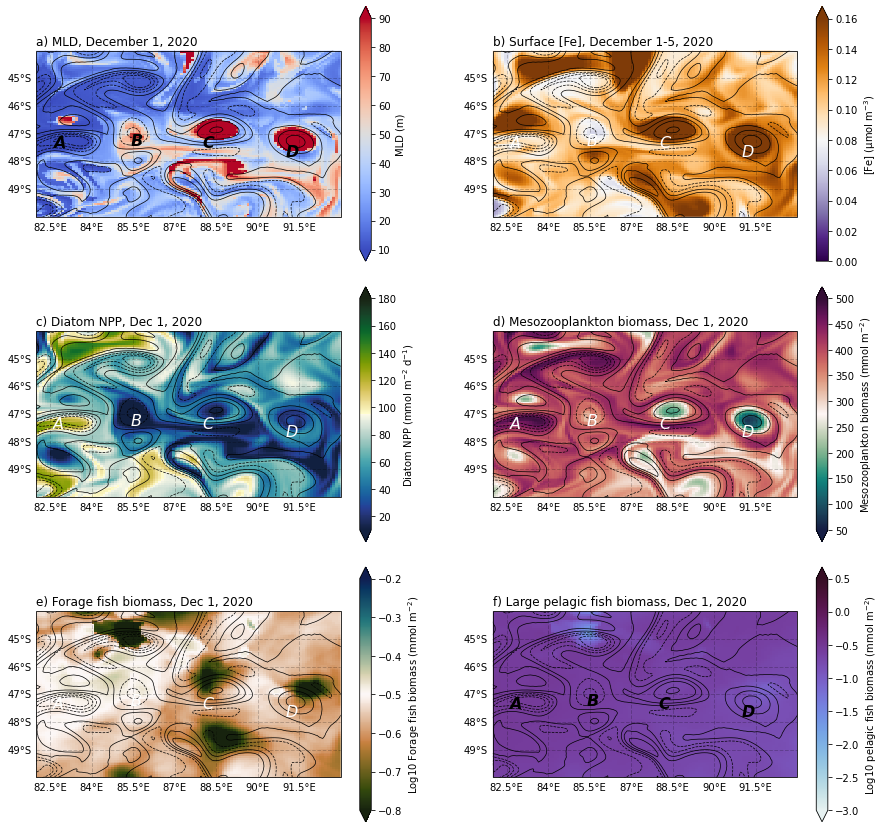

In [65]:
fig = plt.figure(figsize=(15, 15))

gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=(1, 1), height_ratios=(1,1,1))

prj = ccrs.Robinson(central_longitude=305.0)
prj_box = ccrs.PlateCarree()

#ax_zratio = plt.subplot(gs[0,2], projection=prj)
ax_mld = plt.subplot(gs[0,0], projection=prj_box)
ax_fe = plt.subplot(gs[0,1], projection=prj_box)
ax_diat = plt.subplot(gs[1,0], projection=prj_box)
ax_meso = plt.subplot(gs[1,1], projection=prj_box)
ax_forage = plt.subplot(gs[2,0], projection=prj_box)
ax_lp = plt.subplot(gs[2,1], projection=prj_box)

sshcolor = 'black'

##################

# #ax_zratio.set_title('Mean z-ratio', loc='left')
# #lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_mean.zratio)
# #pc=ax_zratio.pcolormesh(lon, lat, field, cmap=cmocean.cm.rain,vmin=0.05,vmax=0.15,transform=ccrs.PlateCarree())
# ax_zratio.coastlines('110m',linewidth=0.5)

# lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
# lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
# ax_zratio.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# #cbar1 = fig.colorbar(pc, ax=ax_zratio,extend='both',label='z-ratio',orientation='horizontal')


##################

ax_mld.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax_mld.set_title('a) MLD, December 1, '+str(year), loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_d1_oneyear.HMXL_2.isel(time=doy)*0.01)

pc = ax_mld.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='coolwarm',
                    vmin=10,vmax=90
                  )


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_mld.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_mld.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

ax_mld.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='black',fontweight='extra bold')
ax_mld.text(85.4,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='black',fontweight='extra bold')
ax_mld.text(88,-47.5,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='black',fontweight='extra bold')
ax_mld.text(91,-47.8,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='black',fontweight='extra bold')


cbar1 = fig.colorbar(pc, ax=ax_mld,extend='both',label='MLD (m)')



##################

ax_fe.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax_fe.set_title('b) Surface [Fe], December 1-5, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, fe_ss_surf*1000)

pc = ax_fe.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='PuOr_r',
                    vmin=0,vmax=0.16
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_fe.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_fe.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

ax_fe.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white')
ax_fe.text(85.4,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white')
ax_fe.text(88,-47.5,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white')
ax_fe.text(91,-47.8,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white')

cbar1 = fig.colorbar(pc, ax=ax_fe,extend='max',label='[Fe] (µmol m$^{-3}$)')
    


############################

ax_diat.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax_diat.set_title('c) Diatom NPP, Dec 1, '+str(year), loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, diatnpp_ss*0.01 * 86400.)
pc = ax_diat.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                    vmin=10,vmax=180
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_diat.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_diat.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

ax_diat.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white')
ax_diat.text(85.4,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white')
ax_diat.text(88,-47.5,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white')
ax_diat.text(91,-47.8,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white')

cbar1 = fig.colorbar(pc, ax=ax_diat,extend='both',label='Diatom NPP (mmol m$^{-2}$ d$^{-1}$)')


###########################

ax_meso.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax_meso.set_title('d) Mesozooplankton biomass, Dec 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, mesozoo_ss*0.01)
pc = ax_meso.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.curl,
                    vmin=50,vmax=500)


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_meso.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_meso.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

ax_meso.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white')
ax_meso.text(85.4,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white')
ax_meso.text(88,-47.5,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white')
ax_meso.text(91,-47.8,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white')

cbar1 = fig.colorbar(pc, ax=ax_meso,extend='both',label='Mesozooplankton biomass (mmol m$^{-2}$)')

############### 

ax_forage.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax_forage.set_title('e) Forage fish biomass, Dec 1, '+str(year), loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, np.log10(forage_ss/12.))

pc = ax_forage.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.tarn,
                    vmin=-0.8,vmax=-0.2)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_forage.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_forage.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

ax_forage.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white')
ax_forage.text(85.4,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white')
ax_forage.text(88,-47.5,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white')
ax_forage.text(91,-47.8,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white')

cbar1 = fig.colorbar(pc, ax=ax_forage,extend='both',label='Log10 Forage fish biomass (mmol m$^{-2}$)')

############### 

ax_lp.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax_lp.set_title('f) Large pelagic fish biomass, Dec 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, np.log10(pelagic_ss/12.))

pc = ax_lp.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.dense,
                    vmin=-3,vmax=0.5)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_lp.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_lp.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False


ax_lp.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='black',fontweight='extra bold')
ax_lp.text(85.4,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='black',fontweight='extra bold')
ax_lp.text(88,-47.5,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='black',fontweight='extra bold')
ax_lp.text(91,-47.8,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='black',fontweight='extra bold')

cbar1 = fig.colorbar(pc, ax=ax_lp,extend='both',label='Log10 pelagic fish biomass (mmol m$^{-2}$)')

fig.subplots_adjust(hspace=0.1)

fig.savefig('/glade/work/kristenk/figs/mesoscale_npp2fish_ss.png', bbox_inches='tight', dpi=300, format='png');

## try zooming in a bit more

In [66]:
##### box in south indian where I'll be showing snapshots
box1_latmin = -50
box1_latmax = -44
box1_lonmin = 82.
box1_lonmax = 93.

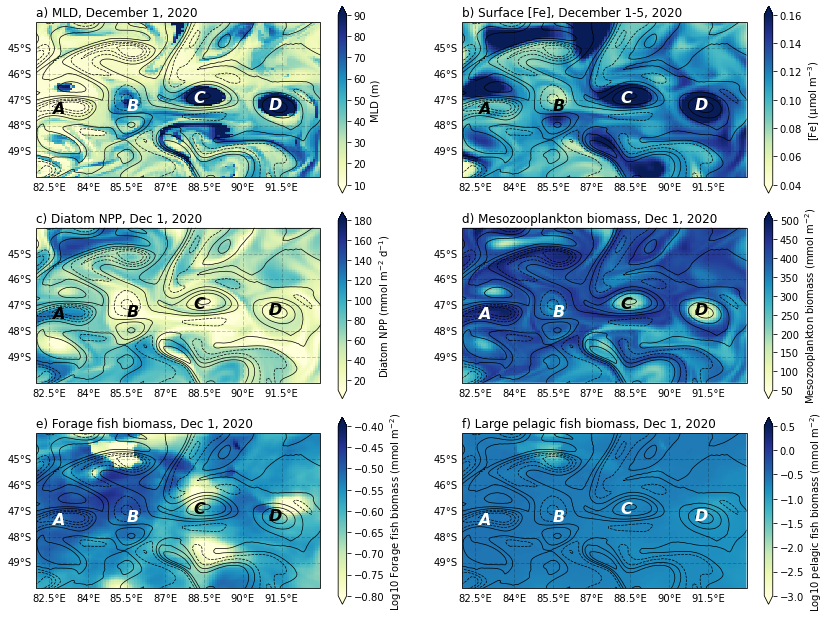

In [67]:
fig = plt.figure(figsize=(14, 11))

cpt='YlGnBu' #'RdYlBu_r'
txt_color='black'

gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=(1, 1), height_ratios=(1,1,1))

prj = ccrs.Robinson(central_longitude=305.0)
prj_box = ccrs.PlateCarree()

#ax_zratio = plt.subplot(gs[0,2], projection=prj)
ax_mld = plt.subplot(gs[0,0], projection=prj_box)
ax_fe = plt.subplot(gs[0,1], projection=prj_box)
ax_diat = plt.subplot(gs[1,0], projection=prj_box)
ax_meso = plt.subplot(gs[1,1], projection=prj_box)
ax_forage = plt.subplot(gs[2,0], projection=prj_box)
ax_lp = plt.subplot(gs[2,1], projection=prj_box)

sshcolor = 'black'

##################

ax_mld.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax_mld.set_title('a) MLD, December 1, '+str(year), loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_d1_oneyear.HMXL_2.isel(time=doy)*0.01)

pc = ax_mld.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cpt,
                    vmin=10,vmax=90
                  )


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_mld.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_mld.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

ax_mld.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_mld.text(85.5,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_mld.text(88.1,-47.1,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_mld.text(91,-47.35,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')


cbar1 = fig.colorbar(pc, ax=ax_mld,extend='both',label='MLD (m)')



##################

ax_fe.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax_fe.set_title('b) Surface [Fe], December 1-5, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, fe_ss_surf*1000)

pc = ax_fe.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cpt,
                    vmin=0.04,vmax=0.16
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_fe.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_fe.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False


ax_fe.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_fe.text(85.5,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_fe.text(88.1,-47.1,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_fe.text(91,-47.35,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')


cbar1 = fig.colorbar(pc, ax=ax_fe,extend='both',label='[Fe] (µmol m$^{-3}$)')
    


############################

ax_diat.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax_diat.set_title('c) Diatom NPP, Dec 1, '+str(year), loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, diatnpp_ss*0.01 * 86400.)
pc = ax_diat.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cpt,
                    vmin=10,vmax=180
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_diat.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_diat.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

ax_diat.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_diat.text(85.5,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_diat.text(88.1,-47.1,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_diat.text(91,-47.35,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')

cbar1 = fig.colorbar(pc, ax=ax_diat,extend='both',label='Diatom NPP (mmol m$^{-2}$ d$^{-1}$)')


###########################

ax_meso.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax_meso.set_title('d) Mesozooplankton biomass, Dec 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, mesozoo_ss*0.01)
pc = ax_meso.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cpt,
                    vmin=50,vmax=500)


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_meso.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_meso.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False


ax_meso.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_meso.text(85.5,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_meso.text(88.1,-47.1,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_meso.text(91,-47.35,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')

cbar1 = fig.colorbar(pc, ax=ax_meso,extend='both',label='Mesozooplankton biomass (mmol m$^{-2}$)')

############### 

ax_forage.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax_forage.set_title('e) Forage fish biomass, Dec 1, '+str(year), loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, np.log10(forage_ss/12.))
#lon,lat,field = utils.adjust_pop_grid(lons, lats, forage_ss)

pc = ax_forage.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cpt,
                    vmin=-0.8,vmax=-0.4)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_forage.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_forage.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

ax_forage.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_forage.text(85.5,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_forage.text(88.1,-47.1,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_forage.text(91,-47.35,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')

cbar1 = fig.colorbar(pc, ax=ax_forage,extend='both',label='Log10 Forage fish biomass (mmol m$^{-2}$)')

############### 

ax_lp.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax_lp.set_title('f) Large pelagic fish biomass, Dec 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, np.log10(pelagic_ss/12.))
#lon,lat,field = utils.adjust_pop_grid(lons, lats, pelagic_ss)

pc = ax_lp.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cpt,
                    vmin=-3,vmax=0.5)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_lp.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_lp.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False


ax_lp.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_lp.text(85.5,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_lp.text(88.1,-47.1,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_lp.text(91,-47.35,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')

cbar1 = fig.colorbar(pc, ax=ax_lp,extend='both',label='Log10 pelagic fish biomass (mmol m$^{-2}$)')

fig.subplots_adjust(hspace=0.1)

#fig.savefig('/glade/work/kristenk/figs/mesoscale_npp2fish_ss.png', bbox_inches='tight', dpi=300, format='png');

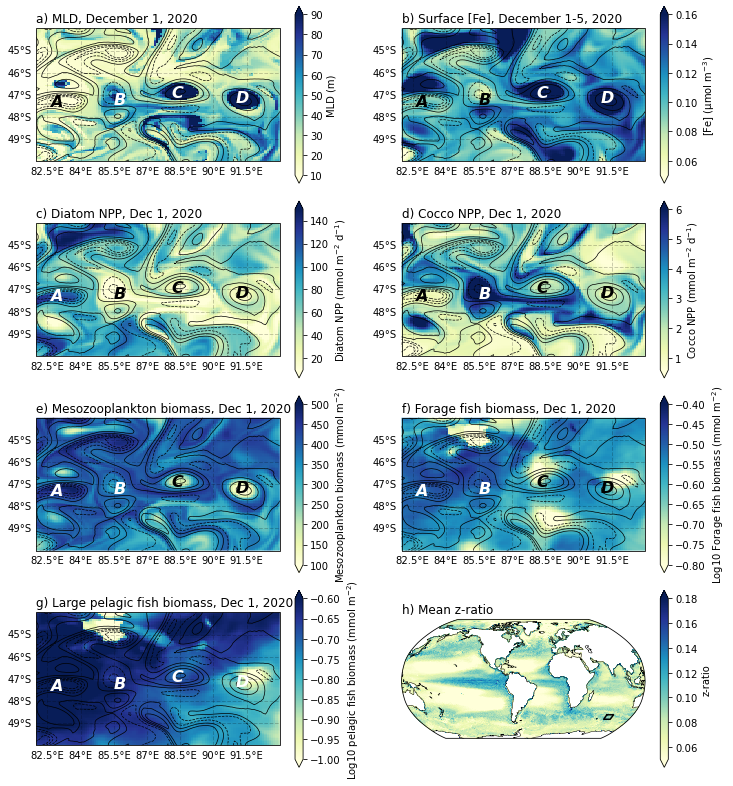

In [71]:
fig = plt.figure(figsize=(12, 14))

cpt='YlGnBu' #'RdYlBu_r'
txt_color='black'

gs = gridspec.GridSpec(nrows=4, ncols=2, width_ratios=(1, 1), height_ratios=(1,1,1,1))

prj = ccrs.Robinson(central_longitude=305.0)
prj_box = ccrs.PlateCarree()

#ax_zratio = plt.subplot(gs[0,2], projection=prj)
ax_mld = plt.subplot(gs[0,0], projection=prj_box)
ax_fe = plt.subplot(gs[0,1], projection=prj_box)
ax_diat = plt.subplot(gs[1,0], projection=prj_box)
ax_cocco = plt.subplot(gs[1,1], projection=prj_box)
ax_meso = plt.subplot(gs[2,0], projection=prj_box)
ax_forage = plt.subplot(gs[2,1], projection=prj_box)
ax_lp = plt.subplot(gs[3,0], projection=prj_box)
ax_glb = plt.subplot(gs[3,1], projection=prj)

sshcolor = 'black'

##################

ax_mld.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax_mld.set_title('a) MLD, December 1, '+str(year), loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_d1_oneyear.HMXL_2.isel(time=doy)*0.01)

pc = ax_mld.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cpt,
                    vmin=10,vmax=90
                  )


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_mld.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_mld.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

ax_mld.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_mld.text(85.5,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_mld.text(88.1,-47.1,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_mld.text(91,-47.35,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')


cbar1 = fig.colorbar(pc, ax=ax_mld,extend='both',label='MLD (m)')



##################

ax_fe.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax_fe.set_title('b) Surface [Fe], December 1-5, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, fe_ss_surf*1000)

pc = ax_fe.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cpt,
                    vmin=0.05,vmax=0.16
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_fe.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_fe.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False


ax_fe.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_fe.text(85.5,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_fe.text(88.1,-47.1,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_fe.text(91,-47.35,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')


cbar1 = fig.colorbar(pc, ax=ax_fe,extend='both',label='[Fe] (µmol m$^{-3}$)')
    


############################

ax_diat.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax_diat.set_title('c) Diatom NPP, Dec 1, '+str(year), loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, diatnpp_ss*0.01 * 86400.)
pc = ax_diat.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cpt,
                    vmin=10,vmax=150
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_diat.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_diat.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

ax_diat.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_diat.text(85.5,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_diat.text(88.1,-47.1,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_diat.text(91,-47.35,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')

cbar1 = fig.colorbar(pc, ax=ax_diat,extend='both',label='Diatom NPP (mmol m$^{-2}$ d$^{-1}$)')

############################

ax_cocco.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax_cocco.set_title('d) Cocco NPP, Dec 1, '+str(year), loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, cocconpp_ss*0.01 * 86400.)
pc = ax_cocco.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cpt,
                    vmin=0.6,vmax=6
                  )

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_cocco.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_cocco.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

ax_cocco.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_cocco.text(85.5,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_cocco.text(88.1,-47.1,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_cocco.text(91,-47.35,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')

cbar1 = fig.colorbar(pc, ax=ax_cocco,extend='both',label='Cocco NPP (mmol m$^{-2}$ d$^{-1}$)')

###########################

ax_meso.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax_meso.set_title('e) Mesozooplankton biomass, Dec 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, mesozoo_ss*0.01)
pc = ax_meso.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cpt,
                    vmin=100,vmax=500)


lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_meso.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_meso.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False


ax_meso.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_meso.text(85.5,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_meso.text(88.1,-47.1,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_meso.text(91,-47.35,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')

cbar1 = fig.colorbar(pc, ax=ax_meso,extend='both',label='Mesozooplankton biomass (mmol m$^{-2}$)')

############### 

ax_forage.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())
ax_forage.set_title('f) Forage fish biomass, Dec 1, '+str(year), loc='left')
lon,lat,field = utils.adjust_pop_grid(lons, lats, np.log10(forage_ss/12.))
#lon,lat,field = utils.adjust_pop_grid(lons, lats, forage_ss)

pc = ax_forage.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cpt,
                    vmin=-0.8,vmax=-0.4)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_forage.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_forage.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

ax_forage.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_forage.text(85.5,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_forage.text(88.1,-47.1,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')
ax_forage.text(91,-47.35,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color=txt_color,fontweight='bold')

cbar1 = fig.colorbar(pc, ax=ax_forage,extend='both',label='Log10 Forage fish biomass (mmol m$^{-2}$)')

############### 

ax_lp.set_extent([box1_lonmin, box1_lonmax, box1_latmin, box1_latmax], ccrs.PlateCarree())

ax_lp.set_title('g) Large pelagic fish biomass, Dec 1, '+str(year), loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, np.log10(pelagic_ss/12.))
#lon,lat,field = utils.adjust_pop_grid(lons, lats, pelagic_ss)

pc = ax_lp.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cpt,
                    vmin=-1,vmax=-0.6)

lon,lat,field = utils.adjust_pop_grid(lons, lats, ssh_anoms)
cs = ax_lp.contour(lon,lat,field, colors=sshcolor,
    levels = np.arange(-9,12,3),
    linewidths = 0.7,
    transform=ccrs.PlateCarree())

gl = ax_lp.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False


ax_lp.text(82.6,-47.5,"A",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_lp.text(85.5,-47.4,"B",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_lp.text(88.1,-47.1,"C",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')
ax_lp.text(91,-47.35,"D",fontstyle='italic',fontsize=16,transform=ccrs.PlateCarree(), color='white',fontweight='bold')

cbar1 = fig.colorbar(pc, ax=ax_lp,extend='both',label='Log10 pelagic fish biomass (mmol m$^{-2}$)')



##################

ax_glb.set_title('h) Mean z-ratio', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_mean.zratio)
pc=ax_glb.pcolormesh(lon, lat, field, cmap=cpt,vmin=0.05,vmax=0.18,transform=ccrs.PlateCarree())
ax_glb.coastlines('110m',linewidth=0.5)

lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax_glb.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax_glb,extend='both',label='z-ratio',orientation='vertical')




fig.subplots_adjust(hspace=0.1)

fig.savefig('/glade/work/kristenk/figs/mesoscale_npp2fish_ss_SInd-box.png', bbox_inches='tight', dpi=300, format='png');